In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Check npy

In [15]:
my_data_path = "data/202055133/arm_rfdata.npy"
refer_data_path = "data/phantom/phantom_rfdata.npy"

In [16]:
my_data = np.load(my_data_path)
refer_data = np.load(refer_data_path)

print("my_data.shape: ", my_data.shape, "refer_data.shape: ", refer_data.shape)

my_data.shape:  (2176, 128, 100) refer_data.shape:  (2176, 128, 100)


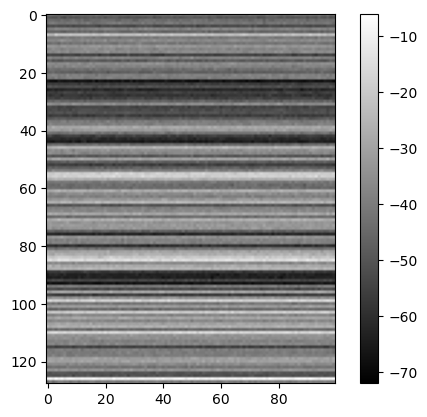

In [19]:
plt.imshow(my_data[0], cmap='gray')
plt.colorbar()
plt.show()